# Adicionando dados de elementos, iluminacao e cor de fundo aos metadados das imagens

Aqui adiciono aos metadados de cada imagem as informações sobre elas (nome dos elementos presentes nas imagens através do nome com que foram salvas, iluminação e cor de fundo, através da organização das imagens em diretórios)

In [40]:
from PIL import Image, PngImagePlugin #uso essa biblioteca apenas para adicionar os metadados as imagens que é uma forma que achei boa de organizar as informacoes na propria imagem, ela nao é usada para mais nada e nao faz parte da construcao do dataset com pandas
import os
import pandas as pd

In [41]:
def adicionar_objetos_metadados(caminho_imagem, lista_objetos, dados): #adiciona as imagens suas infrmacoes (objetos que compoem a imagem, fundo e iluminacao) OBS: Estou usando o PIL apenas para acessar os metadados da imagem como um preprocessamento para o EP e só. A construcao do banco usa apenas os, numpy e pandas

    try:
        imagem = Image.open(caminho_imagem)

        xmp = PngImagePlugin.PngInfo() 
        xmp.add_text("objetos", ",".join(lista_objetos))

        if len(dados) >= 2:
            xmp.add_text("fundo", dados[0])
            xmp.add_text("iluminacao", dados[1])

        caminho_saida = caminho_imagem.split(".")[0] + ".jpeg"
        imagem.save(caminho_saida, "PNG", pnginfo=xmp)

    except Exception as e:
        pass

In [42]:
def imprimir_metadados(caminho_imagem): #funcao auxiliar que imprime os metadados da imagem onde estao os dados relevantes
    try:
        imagem = Image.open(caminho_imagem)

        metadados = imagem.info

        print("Metadados adicionados à imagem:")


        if "objetos" in metadados:
            objetos = metadados["objetos"].split(",")
            print("Objetos:", metadados["objetos"])

        if "fundo" in metadados:
            print("Fundo: ", metadados["fundo"])
        
        if "iluminacao" in metadados:
            print("Iluminacao: ", metadados["iluminacao"])

        else:
            print("Nenhum metadado de objeto encontrado na imagem.")
    except Exception as e:
        pass

In [43]:
def separar_nomes(caminho_imagem): #faz um split para extrair todos os objetos que compoem a imagem (no caso o nome dos objetos que compoem a imagem estao no nome de cada imagem em cada subdiretório)

    nome_arquivo = caminho_imagem.split('/')[-1]
    
    nome_arquivo_sem_extensao = nome_arquivo.split('.')[0]
    
    palavras = nome_arquivo_sem_extensao.split('_')
    
    return palavras

In [44]:
def dados_imagem(diretorio):
    partes = diretorio.split('/')
    partes.pop(0)
    partes.pop(-1)
    return partes



In [45]:
def processar_imagens(diretorio_raiz): #adiciona os metadados a todas as imagens  imagens
    # Percorre todos os diretórios e subdiretórios
    for root, dirs, files in os.walk(diretorio_raiz):
        # Itera sobre os arquivos no diretório atual
        for file in files:
            if file.endswith(".jpeg") or file.endswith(".jpg"):

                caminho_imagem = os.path.join(root, file)
                
                #registra mais dados sobre a imagem no smetadados da imagem 
                dados= dados_imagem(caminho_imagem)
                
                # Separar os objetos do nome da imagem
                objetos = separar_nomes(caminho_imagem)
                
                # Adicionar metadados aos objetos
                adicionar_objetos_metadados(caminho_imagem, objetos, dados)
                

In [46]:
# Processar todas as imagens nos subdiretórios
processar_imagens("EP1")

### Exemplo de metadados adicionados a imagem:

1 - Elementos presentes na imagem

2 - Cor do fundo

3 - Intensidade da iluminacao


In [47]:
imprimir_metadados("EP1/branco/alta/agulhadetrico_agulhadecroche_novelo_agulha.jpeg")

Metadados adicionados à imagem:
Objetos: agulhadetrico,agulhadecroche,novelo,agulha
Fundo:  branco
Iluminacao:  alta


______________________________________________________________________________________

# Criando as classes de objetos presentes no database

Percorrendo o DB e contabilizando todos os dados releantes para a construcao das tabelas 

In [48]:
elementos = []
count_imagens = 0
total_bytes = 0
resolucao_das_imagens = 0


try:
    for root, dirs, files in os.walk("EP1"):
        for file in files:
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                caminho_imagem = os.path.join(root, file)
                
                #extrai os metadados da imagem
                imagem = Image.open(caminho_imagem)
                metadados = imagem.info

                #soma para o tamanho total em bytes do banco
                tamanho_bytes = os.path.getsize(caminho_imagem)
                total_bytes += tamanho_bytes

                #conta a quantidade de imagens 
                count_imagens += 1

                #captura a resoloucao das imagens (todas tem a mesma resolucao)
                resolucao_das_imagens = imagem.size

                #verifica quantas classes tem na base de dados 
                if "objetos" in metadados:
                    objetos = metadados["objetos"].split(",")
                    
                    for objeto in objetos:
                        if objeto not in elementos:  
                            elementos.append(objeto)


except Exception as e:
    pass




______________________________________________________________________________________

# Tabela Sumária dos Dados

In [49]:
classes = elementos
n_classes = len(classes)
n_imagens = count_imagens
total_mb = total_bytes / (1024 * 1024)

print("==========================Tabela GlobalSumária=======================================================================================================================\n")
print("Nome das classes: ", classes)
print("Número de classes: ", n_classes)
print("Número das imagens: ", n_imagens)
print("Tamanho da base (bytes): ", total_mb, "MB")
print("Resolucao das imagens: ", resolucao_das_imagens)
print("======================================================================================================================================================================\n")



==========================Tabela GlobalSumária=======================================================================================================================

Nome das classes:  ['agulhadetrico', 'agulhadecroche', 'novelo', 'agulha', 'caderno', 'caneta', 'lapis', 'protetor', 'batom', 'pincel', 'chaveferramenta', 'parafuso']
Número de classes:  12
Número das imagens:  28
Tamanho da base (bytes):  18.3429594039917 MB
Resolucao das imagens:  (1600, 1200)



______________________________________________________________________________________

# Tabela Detalhada por Classes 

Aqui percorro o database extraindo as informacoes relevante para a construcao da tabela detalhada por classe. vou extrair as informacoe para construir as colunas classe, fundo e iluminacoes. No caso, vou percorrer classe por classe para construir essas colunas

In [50]:
classes_info = []

print(classes)

for classe in classes:
    fundos = []
    iluminacoes = []

    try:
        for root, dirs, files in os.walk("EP1"):
            folder_name = os.path.basename(root)
            # print(folder_name)
            for file in files:
                if file.endswith((".jpeg", ".jpg")):
                    caminho_imagem = os.path.join(root, file)

                    # Extrai os metadados da imagem
                    with Image.open(caminho_imagem) as imagem:
                        metadados = imagem.info

                    objetos = metadados["objetos"]

                    if classe in objetos:
                        if "fundo" in metadados:
                            fundo = metadados["fundo"]
                            if fundo not in fundos:
                                fundos.append(fundo)

                        if "iluminacao" in metadados:
                            iluminacao = metadados["iluminacao"]
                            if iluminacao not in iluminacoes:
                                iluminacoes.append(iluminacao)
        classe_info = {
            "Classes": classe,
            "Variacoes de fundos": fundos,
            "Variacoes de iluminacoes": iluminacoes
        }

        classes_info.append(classe_info)

        # print("Fundos:", fundos)
        # print("Iluminações:", iluminacoes)
    except Exception as e:
        print(f"Ocorreu um erro na classe {classe}: {e}")
        continue

['agulhadetrico', 'agulhadecroche', 'novelo', 'agulha', 'caderno', 'caneta', 'lapis', 'protetor', 'batom', 'pincel', 'chaveferramenta', 'parafuso']


In [51]:
#adicione essas infos a tabela 
df = pd.DataFrame(classes_info)
df

,Classes,Variacoes de fundos,Variacoes de iluminacoes
0,agulhadetrico,"[branco, marrom]","[alta, media, baixa]"
1,agulhadecroche,"[branco, marrom]","[baixa, alta, media]"
2,novelo,"[branco, marrom]","[alta, media, baixa]"
3,agulha,"[branco, marrom]","[baixa, alta, media]"
4,caderno,"[branco, marrom]","[baixa, alta, media]"
5,caneta,"[branco, marrom]","[baixa, alta, media]"
6,lapis,"[branco, marrom]","[baixa, alta, media]"
7,protetor,"[branco, marrom]","[baixa, alta, media]"
8,batom,"[branco, marrom]","[baixa, alta, media]"
9,pincel,"[branco, marrom]","[baixa, alta, media]"


continuando: para verificar o tamanho total das amostras eu vou criar um vetor de tuplas no qual a primeira posicao diz respeito a qual classe me refiro e a segunda posicao a quantidade total da amostra que temos daquela classe em todo DB.

In [52]:
#inicializo com zero
amostras = []

for ele in classes:
    amostras.append((ele, 0))

amostras

[('agulhadetrico', 0),
 ('agulhadecroche', 0),
 ('novelo', 0),
 ('agulha', 0),
 ('caderno', 0),
 ('caneta', 0),
 ('lapis', 0),
 ('protetor', 0),
 ('batom', 0),
 ('pincel', 0),
 ('chaveferramenta', 0),
 ('parafuso', 0)]

Além disso, para ficar similar ao exemplo fornecido, vou contar quantas repeticoes acontecem de cada elemento para todas as combinacoes de iluminacao e fundo

In [53]:
def verifica_amostras_e_repeticao(iluminacao, fundo, root):
    repeticao = []

    for ele in classes:
        repeticao.append((ele, 0))


    for imagem in os.listdir(root):
        if imagem.lower().endswith(".jpeg"):  
            elementos = separar_nomes(os.path.join(root, imagem))

            for elemento in elementos:
                for i, tupla in enumerate(amostras):
                    if tupla[0] == elemento:
                        amostras[i] = (elemento, tupla[1] + 1) #incrementa o total de amostra
                for i, tupla in enumerate(repeticao):
                    if tupla[0] == elemento:
                        repeticao[i] = (tupla[1] + 1, fundo, iluminacao) #incrementa a repeticao para essa iluminacao e fundo
    
    return repeticao #retorna o total de repeticao para esse fundo e essa iluminacao para cada elemento


In [54]:
fundo = ""
iluminacao = ""
col_repeticao = []  # initializing the repetition count vector
repeticao_elementos = []

for folder_name in classes:  # Assuming classes is defined elsewhere
    repeticao_elementos.append([])  # Initialize an empty list for each class

try:
    for root, dirs, files in os.walk("EP1"):
        folder_name = os.path.basename(root)
        partes = root.split("/")
        if len(partes) >= 3:
            fundo = partes[-2] 
            iluminacao = partes[-1]  

        if fundo in fundos and iluminacao in iluminacoes:
            repeticao = verifica_amostras_e_repeticao(iluminacao, fundo, root)

            for i in range(len(repeticao_elementos)):
                repeticao_elementos[i].append(repeticao[i]) #construo a coluna final que conterá, para cada classe, os registros de repeticao para um dado fundo e iluminacao
     
except FileNotFoundError as e:
    print("Directory not found:", e)
except Exception as e:
    print("An error occurred:", e)




In [55]:
amostras
amostra = []
for r in amostras:
    amostra.append(r[1]) #pego apenas o segundo registro para criar a coluna da quantidade de amostras para cada classe


In [56]:
#crio as 2 novas colunas
df['Total de amostras'] = amostra
df['Número de repeticoes (repeticoes, fundo, iluminacao)'] = repeticao_elementos

Observe: na coluna repeticao eu tenho os registros do elemento_i: (quantidade de repeticao, fundo, iluminacao). Ou seja, para cada fundo e iluminacao tenho a quantidade de repeticoes do elemento_i.

In [57]:
df

,Classes,Variacoes de fundos,Variacoes de iluminacoes,Total de amostras,"Número de repeticoes (repeticoes, fundo, iluminacao)"
0,agulhadetrico,"[branco, marrom]","[alta, media, baixa]",6,"[(1, branco, baixa), (1, branco, alta), (1, br..."
1,agulhadecroche,"[branco, marrom]","[baixa, alta, media]",12,"[(1, branco, baixa), (1, branco, alta), (1, br..."
2,novelo,"[branco, marrom]","[alta, media, baixa]",5,"[(1, branco, baixa), (1, branco, alta), (1, br..."
3,agulha,"[branco, marrom]","[baixa, alta, media]",6,"[(1, branco, baixa), (1, branco, alta), (1, br..."
4,caderno,"[branco, marrom]","[baixa, alta, media]",10,"[(1, branco, baixa), (1, branco, alta), (1, br..."
5,caneta,"[branco, marrom]","[baixa, alta, media]",6,"[(1, branco, baixa), (1, branco, alta), (1, br..."
6,lapis,"[branco, marrom]","[baixa, alta, media]",6,"[(1, branco, baixa), (1, branco, alta), (1, br..."
7,protetor,"[branco, marrom]","[baixa, alta, media]",6,"[(1, branco, baixa), (1, branco, alta), (1, br..."
8,batom,"[branco, marrom]","[baixa, alta, media]",10,"[(1, branco, baixa), (1, branco, alta), (1, br..."
9,pincel,"[branco, marrom]","[baixa, alta, media]",10,"[(1, branco, baixa), (1, branco, alta), (1, br..."


________________________________________________________________________________________

# Imprime alguns exemplos de imagens que contem o objeto especificado 

Plotando imagens presentes no data que o usuário quer ver

Imagem com o objeto encontrado: EP1/branco/baixa/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/branco/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/media/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/protetor_pincel.jpeg
Imagem com o objeto encontrado: EP1/marrom/alta/protetor_batom_pincel.jpeg
===================== OBJETO:  pincel ======================
Erro ao plotar a imagem: EP1/marrom/baixa/protetor_pincel.jpeg
Erro: image file is truncated


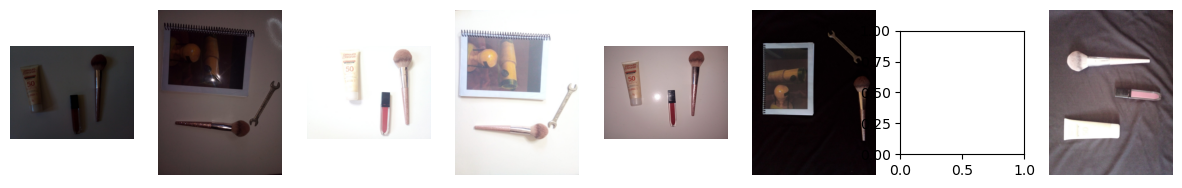

Imagem com o objeto encontrado: EP1/branco/baixa/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Imagem com o objeto encontrado: EP1/branco/media/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Imagem com o objeto encontrado: EP1/marrom/media/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
===================== OBJETO:  novelo ======================
Erro ao plotar a imagem: EP1/branco/baixa/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Erro: image file is truncated
Erro ao plotar a imagem: EP1/marrom/media/agulhadetrico_agulhadecroche_novelo_agulha.jpeg
Erro: image file is truncated


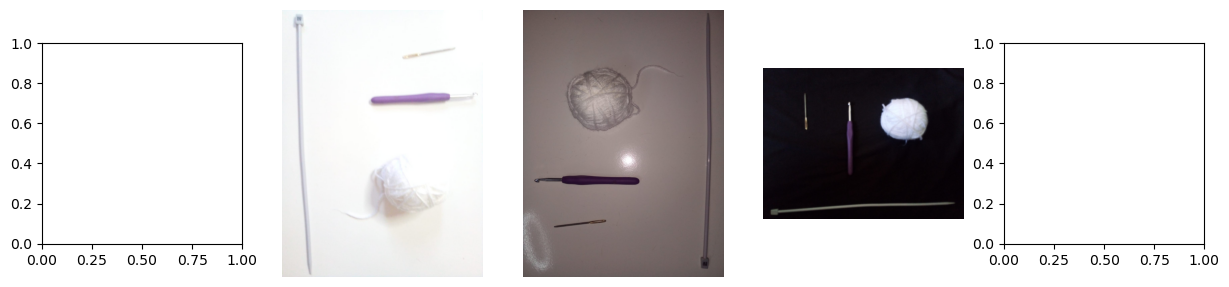

Imagem com o objeto encontrado: EP1/branco/baixa/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/branco/baixa/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/media/batom_agulhadecroche_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/media/protetor_batom_pincel.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/alta/protetor_batom_pincel.jpeg
===================== OBJETO:  batom ======================


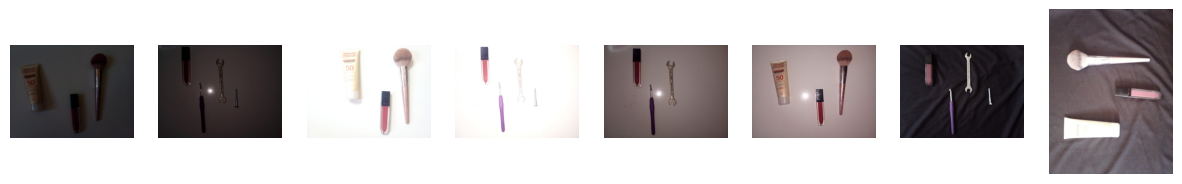

Imagem com o objeto encontrado: EP1/branco/baixa/caderno_caneta_lapis.jpeg
Imagem com o objeto encontrado: EP1/branco/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/caderno_caneta_lapis.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/media/caderno_caneta_lapis.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/caderno_caneta_lapis.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/alta/caderno_caneta_lapis.jpeg
===================== OBJETO:  caderno ======================
Erro ao plotar a imagem: EP1/marrom/alta/caderno_caneta_lapis.jpeg
Erro: image file is truncated


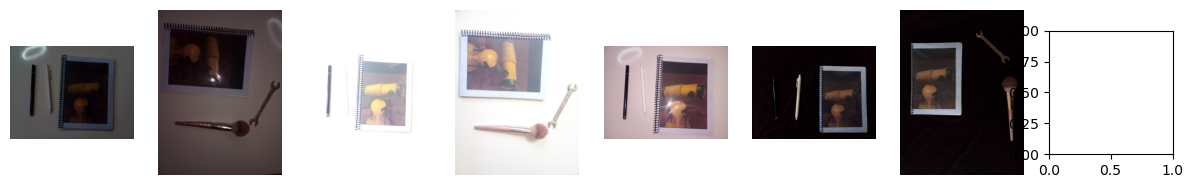

Imagem com o objeto encontrado: EP1/branco/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/baixa/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/alta/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/branco/media/batom_agulhadecroche_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/caderno_pincel_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/baixa/batom_agulhadecroche_parafuso_chaveferramenta.jpeg
Imagem com o objeto encontrado: EP1/marrom/alta/caderno_pincel_chaveferramenta.jpeg
===================== OBJETO:  chaveferramenta ======================
Erro ao plotar a imagem: EP1/marrom/alta/caderno_pincel_chaveferramenta.jpeg
Erro: image file is truncated


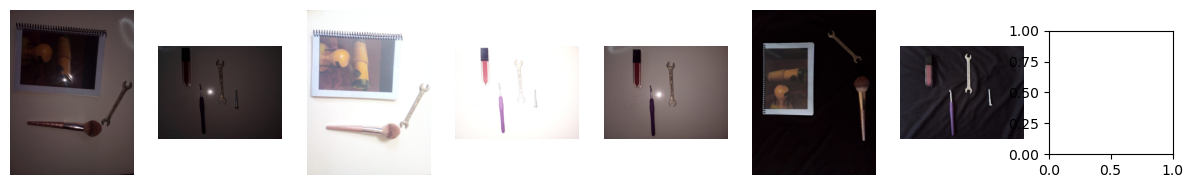

In [58]:
import os
from PIL import Image #uso o PIL apenas para acessar os metadados da imagem, mas nao construo o data base com ele 
import matplotlib.pyplot as plt

def encontrar_imagens_com_objeto(objeto, limite=8):
    imagens_encontradas = 0
    caminhos_imagens = []
    
    for root, dirs, files in os.walk("EP1"):
        for file in files:
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                caminho_imagem = os.path.join(root, file)
                
                try:
                    imagem = Image.open(caminho_imagem)
                    metadados = imagem.info

                    if "objetos" in metadados:
                        objetos = metadados["objetos"].split(",")

                        if objeto in objetos:
                            print("Imagem com o objeto encontrado:", caminho_imagem)
                            caminhos_imagens.append(caminho_imagem)
                            imagens_encontradas += 1

                            if imagens_encontradas == limite:
                                return caminhos_imagens
                except Exception as e:
                    pass
    
    if imagens_encontradas == 0:
        print("Nenhuma imagem encontrada com o objeto:", objeto)
    return caminhos_imagens

def plotar_imagens(caminhos_imagens):
    try:
        num_imagens = len(caminhos_imagens)
        fig, axs = plt.subplots(1, num_imagens, figsize=(15, 5))

        for i, caminho_imagem in enumerate(caminhos_imagens):
            try:
                imagem = Image.open(caminho_imagem)
                axs[i].imshow(imagem)
                axs[i].axis('off')
            except Exception as e:
                print("Erro ao plotar a imagem:", caminho_imagem)
                print("Erro:", e)
        
        plt.show()
    except Exception as e:
        pass

try:
    obj = "pincel" # EXEMPLO DE OBJETO
    caminhos_imagens = encontrar_imagens_com_objeto(obj)

    if caminhos_imagens:
        print("===================== OBJETO: ", obj, "======================")
        plotar_imagens(caminhos_imagens)

    obj = "novelo" # EXEMPLO DE OBJETO
    caminhos_imagens = encontrar_imagens_com_objeto(obj)

    if caminhos_imagens:
        print("===================== OBJETO: ", obj, "======================")
        plotar_imagens(caminhos_imagens)

    obj = "batom" # EXEMPLO DE OBJETO
    caminhos_imagens = encontrar_imagens_com_objeto(obj)

    if caminhos_imagens:
        print("===================== OBJETO: ", obj, "======================")
        plotar_imagens(caminhos_imagens)

    obj = "caderno" # EXEMPLO DE OBJETO
    caminhos_imagens = encontrar_imagens_com_objeto(obj)

    if caminhos_imagens:
        print("===================== OBJETO: ", obj, "======================")
        plotar_imagens(caminhos_imagens)

    obj = "chaveferramenta" # EXEMPLO DE OBJETO
    caminhos_imagens = encontrar_imagens_com_objeto(obj)

    if caminhos_imagens:
        print("===================== OBJETO: ", obj, "======================")
        plotar_imagens(caminhos_imagens)
    
except Exception as e:
    print("Erro:", e)
